In [1]:
# baseline cnn model
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.optimizers import SGD
from os import listdir
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
def extract_features(filename):
    # Loading and resizing image
    image = load_img(filename, target_size=(400,500))
    # Convert the image pixels to a numpy array
    image = img_to_array(image, "channels_first")
    # Reshape data for the model
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    return image

In [29]:
# load train and test dataset
def load_dataset(pathImages, pathLabeled):
    onlyfiles = [f for f in os.listdir(pathImages) if os.path.isfile(os.path.join(pathImages, f))]
    
    train_files = []
    y_train = []
    i=0
    for _file in onlyfiles:
        train_files.append(_file)

    image_width = 1000
    image_height = 800
    ratio = 2

    image_width = int(image_width / ratio)
    image_height = int(image_height / ratio)

    channels = 3
    nb_classes = 1

    dataset = np.ndarray(shape=(len(train_files), channels, image_height, image_width),
                         dtype=np.float32)
    i = 0
    for _file in train_files:
        dataset[i] = extract_features(pathImages + "/" + _file)
        i += 1
        if i % 100 == 0:
            print("%d images to array" % i)
    print("All images to array!")

    z_train, y_train = np.loadtxt(pathLabeled, delimiter=' | ', unpack = True)
    
    from sklearn.model_selection import train_test_split

    #Splitting 
    X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.4, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
    print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))
    
    return X_train, y_train, X_test, y_test, X_val, y_val

In [4]:
# define cnn model
def define_model():
        
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(3, 400, 500)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
#   compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=0, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, model, history):
	scores, histories = list(), list()
	# evaluate model
	_, acc = model.evaluate(dataX, dataY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# stores scores
	scores.append(acc)
	histories.append(history)
	return scores, histories

In [24]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	# plot loss
	print(histories[0].history['loss'])
	print(histories[0].history)
	pyplot.subplot(2, 1, 1)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(histories[0].history['loss'], color='blue', label='train')
	pyplot.plot(histories[0].history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.title('Classification Accuracy')
	pyplot.plot(histories[0].history['accuracy'], color='blue', label='train')
	pyplot.plot(histories[0].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

In [10]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

In [30]:
trainX, trainY, testX, testY, X_val, y_val = load_dataset('C:\images\second-batch', 'C:\images\second-batch\labeled\\temporal.txt')

100 images to array
200 images to array
300 images to array
400 images to array
500 images to array
600 images to array
700 images to array
800 images to array
900 images to array
1000 images to array
All images to array!
Train set size: 600, Val set size: 200, Test set size: 200


In [31]:
# run the test harness for evaluating a model
def run_test_harness(trainX, trainY, testX, testY, X_val, y_val):
    # define model
    print('iniciating definition of the model')
    model = define_model()
    # prepare pixel data
#     print('iniciating the  preparation of pixel data')
#     trainX, testX = prep_pixels(trainX, testX)
    # fit model
    print('iniciating the fit of the model')
    history = model.fit(trainX, trainY, epochs=5, batch_size=32, verbose=0, validation_data=(X_val, y_val))
    # evaluate model
    print('iniciating theevaluation of the model')
    scores, histories = evaluate_model(testX, testY, model, history)
    # learning curves
    print('iniciating the diagnostics')
    summarize_diagnostics(histories)
    # summarize estimated performance
    print('iniciating the diagnostic of performance')
    summarize_performance(scores)
    model.summary()
    # save model
    print('saving the model')
    model.save('final_model.h5')

iniciating definition of the model
iniciating the fit of the model
iniciating theevaluation of the model
> 48.000
iniciating the diagnostics
[nan, 0.698288037776947, 0.695469540754954, 0.6941864935557047, 0.6932697709401449]
{'val_loss': [0.7042730164527893, 0.6992637848854065, 0.6956194043159485, 0.692315878868103, 0.6891736507415771], 'val_accuracy': [0.4399999976158142, 0.4399999976158142, 0.4399999976158142, 0.4399999976158142, 0.5649999976158142], 'loss': [nan, 0.698288037776947, 0.695469540754954, 0.6941864935557047, 0.6932697709401449], 'accuracy': [0.45833334, 0.49166667, 0.49166667, 0.49166667, 0.48833334]}


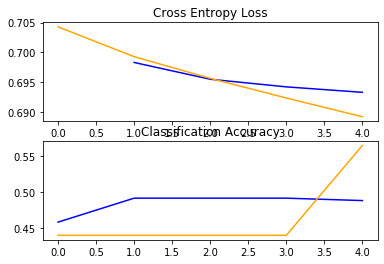

iniciating the diagnostic of performance
Accuracy: mean=48.000 std=0.000, n=1


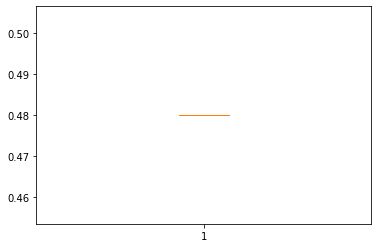

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 1, 398, 64)        288064    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 199, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 199, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 199, 128)       8320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 100, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)              

In [32]:
# entry point, run the test harness
run_test_harness(trainX, trainY, testX, testY, X_val, y_val)

In [ ]:
trainX2, trainY2, testX2, testY2, X_val2, y_val2 = load_dataset('C:\images\second-batch', 'C:\images\second-batch\labeled\\temporal.txt')

In [ ]:
def keep_training_to_be_mamadisimo(trainX2, trainY2, testX2, testY2, X_val2, y_val2):
    model = load_model('final_model.h5')
    print('iniciating the  preparation of pixel data')
    trainX, testX = prep_pixels(trainX2, testX2)
    # fit model
    print('iniciating the fit of the model')
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0, validation_data=(X_val2, y_val2))
    # evaluate model
    print('iniciating theevaluation of the model')
    scores, histories = evaluate_model(testX, testY, model, history)
    # learning curves
    print('iniciating the diagnostics')
    summarize_diagnostics(histories)
    # summarize estimated performance
    print('iniciating the diagnostic of performance')
    summarize_performance(scores)
    # save model
    print('saving the model')
    model.save('final_model.h5')

In [ ]:
keep_training_to_be_mamadisimo()

In [ ]:
def run_example():
    # load model
    model = load_model('final_model.h5')
# load the images
    #img = np.ndarray(shape=(1, 3, 400, 500),
    #                    dtype=np.float32)
    
    image = load_img('blanco.png')
    input_arr = img_to_array(image, "channels_first")
    input_arr = np.array([input_arr])  # Convert single image to a batch.

    #img[0] = extract_features('blanco.png')
    #print (img.shape)
    
    # predict the class
    digit = model.predict(input_arr)
    print(digit)
def load_image(filename):
# load the image
    img = load_img(filename, grayscale=False, target_size=(800, 1000))
# convert to array
    img = img_to_array(img)
# reshape into a single sample with 1 channel
    img = img.reshape(3,400,500)
# prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [ ]:
# trainX2, trainY2, testX2, testY2 = load_dataset('C:\carpetaInutil', 'C:\etiquetadoMal.txt')

In [ ]:
# entry point, run the example
run_example()